# ML Engineering: Predicting Patient Death During EMS Transport

### Import Packages:

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

shap.initjs()


### Import data
Here we import the data and rename columns for better interpretability

In [39]:
df = pd.read_csv("DABP_Raw_data.csv")

df = df.rename(
    columns={
        "eDispatch_01": "Disp_Complaint_Reported",
        "eDispatch_02": "EMD_Performed",
        "eDisposition_12": "Patient_Disposition",
        "eDisposition_19": "Final_Patient_Acuity",
        "eDisposition_16": "Transport_Mode",
        "eDisposition_21": "Destination",
        "eDisposition_22": "Hospital_Inpatient_Destination",
        "eOutcome_01": "Emergency_Department_Disposition",
        "eOutcome_02": "Hospital_Disposition",
        "ePatient_13": "Gender",
        "ePatient_15": "Age",
        "ePatient_16": "Age_Units",
        "ePayment_50": "CMS_Service_Level",
        "eResponse_05": "Response_Type_Service_Requested",
        "eResponse_23": "Response_Mode_to_Scene",
        "eScene_01": "First_EMS_Unit_Scene",
        "eScene_06": "Number_of_Patients_Scene",
        "eScene_07": "Mass_Casualty_Incident",
        "eScene_08": "Triage_Classification_MCI",
        "eScene_09": "Incident_Location_Type",
        "eSituation_02": "Possible_Injury",
        "'eSituation_07'": "Chief_Complaint_Anatomic_Location",
        "'eSituation_08'": "Chief_Complaint_Organ_System",
        "eSituation_13": "Initial_Patient_Acuity",
        "'eSituation_01'": "Date/Time_of_Symptom_Onset",
        "eTimes_01": "PSAP_Call_Date/Time",
        "eTimes_03": "Unit_Notified_Dispatch_Date/Time",
        "eTimes_05": "Unit_En_Route_Date/Time",
        "eTimes_06": "Unit_Arrived on Scene Date/Time",
        "eTimes_07": "Arrived_at_Patient_Date/Time",
        "eTimes_09": "Unit_Left_Scene_Date/Time",
        "eTimes_11": "Patient_Arrived_at_Destination_Date/Time",
        "eTimes_12": "Destination_Patient_Transfer_of_Care_Date/Time",
        "eTimes_13": "Unit Back in Service Date/Time",
        "eDisposition_17": "Transport_Mode_from_Scene",
        "CensusRegion": "Census_Region",
        "CensusDivision": "Census_Division",
        "'Urbanicity'": "Urbanicity",
        "eHistory_17": "Alcohol/Drug_Use_Indicators",
        "eInjury_01": "Cause_of_Injury",
        "eDisposition_20": "Reason_for_Choosing_Destination",
        "eDisposition_25": "Date/Time_of_Destination_Prearrival_Alert",
        "eDisposition_24": "Destination_Team_Pre-Arrival_Alert",
        "eResponse_08": "Type_of_Dispatch_Delay",
        "eInjury_04": "Vehicular_Pedestrian_Injury_Risk_Factor",
        "eSituation_09": "Primary_Symptom",
        "eResponse_09": "Type_of_Response_Delay",
        "eResponse_10": "Type_of_Scene_Delay",
        "eResponse_11": "Type_of_Transport_Delay",
        "eVitals_01": "Date/Time_Vital_Signs_Taken",
        "eVitals_06": "Systolic_Blood_Pressure",
        "eVitals_10": "Heart_Rate",
        "eVitals_12": "Pulse_Oximetry",
        "eVitals_14": "Respiratory_Rate",
        "eVitals_16": "End_Tidal_Carbon_Dioxide",
        "eVitals_18": "Blood_Glucose_Level",
        "eVitals_27": "Pain_Scale_Score",
        "eVitals_02": "Obtained_Prior_to_this_Unit_EMS_Care",
        "eVitals_04": "ECG_Type",
        "eVitals_08": "Method_of_Blood_Pressure_Measurement",
        "eVitals_26": "Level_of_Responsiveness",
        "eVitals_29": "Stroke_Scale_Score",
        "eVitals_30": "Stroke_Scale_Type",
        "eVitals_31": "Reperfusion_Checklist",
        "eVitals_19": "Glasgow_Coma_Score_Eye",
        "eVitals_20": "Glasgow_Coma_Score_Verbal",
        "eVitals_21": "Glasgow_Coma_Score_Motor",
        "ePatient_14": "Race",
        "eHistory_01": "Barriers_to_Patient_Care",
        "eMedications_03": "Date/Time_Medication_Administered",
        "eMedications_05": "Medication_Dosage",
        "eMedications_06": "Medication_Dosage_Units",
        "eMedications_07": "Response_to_Medication",
        "eMedications_10": "Role_of_Person_Administering_Medication",
        "eMedications_02": "Medication_Administered_Prior_Unit_EMS_Care",
        "eMedications_01": "Date/Time_Medication_Administered",
        "eInjury_03": "Trauma_Center_Criteria",
    }
)


Columns (77,82) have mixed types. Specify dtype option on import or set low_memory=False.


In [40]:
# Example output
df

,PcrKey,Disp_Complaint_Reported,EMD_Performed,Patient_Disposition,Final_Patient_Acuity,Transport_Mode,Destination,Hospital_Inpatient_Destination,Emergency_Department_Disposition,Hospital_Disposition,...,PcrMedicationKey,Date/Time_Medication_Administered,eMedications_03Descr,Medication_Dosage,Medication_Dosage_Units,Response_to_Medication,Role_of_Person_Administering_Medication,Medication_Administered_Prior_Unit_EMS_Care,Date/Time_Medication_Administered,Trauma_Center_Criteria
0,29723657,2301021,2302007,4212033,7701003,4216005,4221003,7701003,7701003,7701003,...,117368708,317361,EPINEPHrine 0.1 MG/ML,1.0,3706021,9916001,9905013,9923001,2019-01-16 12:28:34,7701003
1,29723657,2301021,2302007,4212033,7701003,4216005,4221003,7701003,7701003,7701003,...,117368708,317361,EPINEPHrine 0.1 MG/ML,1.0,3706021,9916001,9905013,9923001,2019-01-16 12:28:34,7701003
2,36585551,2301059,7701003,4212033,7701003,4216005,4221003,7701003,7701003,7701003,...,118882227,7701003,Not Recorded,0.0,7701003,7701003,7701003,7701003,Not Recorded,7701003
3,36585551,2301059,7701003,4212033,7701003,4216005,4221003,7701003,7701003,7701003,...,118882227,7701003,Not Recorded,0.0,7701003,7701003,7701003,7701003,Not Recorded,7701003
4,38930737,2301071,7701001,4212033,4219005,4216005,4221007,7701001,7701003,7701003,...,108893409,7701001,Not Applicable,0.0,7701001,7701001,7701001,7701001,Not Applicable,7701001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1212637,80024875,2301061,2302003,4212033,4219005,4216005,4221003,7701001,7701003,7701003,...,125092049,161,Acetaminophen,1000.0,3706021,7701003,9905009,9923001,2019-08-12 13:05:00,7701003
1212638,80033457,2301021,7701003,4212033,7701003,4216005,4221003,7701001,7701003,7701003,...,125132750,4917,Nitroglycerin,0.4,3706021,9916003,7701003,9923001,2019-07-26 14:55:00,7701001
1212639,80033457,2301021,7701003,4212033,7701003,4216005,4221003,7701001,7701003,7701003,...,125132749,4917,Nitroglycerin,0.4,3706021,9916003,7701003,9923001,2019-07-26 14:42:00,7701001
1212640,80033457,2301021,7701003,4212033,7701003,4216005,4221003,7701001,7701003,7701003,...,125132750,4917,Nitroglycerin,0.4,3706021,9916003,7701003,9923001,2019-07-26 14:55:00,7701001


## Feature Selection
In this case, we are dealing with a lot of categorical variables with multiple interpretable meanings. Not much of the data can be interpreted numerically, and therefore we will have to either exclude it or develop our own numerical interpretation.

First is the outcome variable. We are trying to figure out what features are important for predicting patient death, therefore we can prioritize calls with those aspects when optimizing routing. We will use eoutcome 01 and eoutcome 02 for the outcome, which we will combine to form our y vector.

Keys with 20 indicates the patient has died either en route ot the hospital or while in the hospital's care, indicating it may be a situation where quicker response could have saved them. entries with 7701003 and 7701001 indicate that the column was not filed or not applicible, indicating no hospital transport. Therefore, these rows will be removed from our analysis.

In [41]:
ed_df = df.loc[
    (df["Emergency_Department_Disposition"] != 7701003)
    & (df["Emergency_Department_Disposition"] != 7701001)
]


In [42]:
hosp_df = df.loc[
    (df["Hospital_Disposition"] != 7701003) & (df["Hospital_Disposition"] != 7701001)
]


If a patient shows up in at least one of the two above dataframes, we know that they were transported to the hospial in the event

In the next cell, we take the union of the above two sets to get the index of every patient who was transported, and then use those indicies to build a new filtered dataset that contains only the patients that were transported to a hospital for any reason.

In [43]:
# Create index of all patients that were transported
transport_index = ed_df.index.union(hosp_df.index)

ML_df = df.iloc[transport_index]

Now, we will create out outcome variable by filtering the data so that any row with hospital or ER dispositio code 20 is recorded as deceased in transit

In [44]:
ML_df["patient_death"] = 0
ML_df.loc[
    (ML_df["Hospital_Disposition"] == 20)
    | (ML_df["Emergency_Department_Disposition"] == 20),
    "patient_death",
] = 1



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [45]:
# 579 positive samples, the data is very unbalanced
ML_df.loc[ML_df["patient_death"] == 1]


,PcrKey,Disp_Complaint_Reported,EMD_Performed,Patient_Disposition,Final_Patient_Acuity,Transport_Mode,Destination,Hospital_Inpatient_Destination,Emergency_Department_Disposition,Hospital_Disposition,...,Date/Time_Medication_Administered,eMedications_03Descr,Medication_Dosage,Medication_Dosage_Units,Response_to_Medication,Role_of_Person_Administering_Medication,Medication_Administered_Prior_Unit_EMS_Care,Date/Time_Medication_Administered,Trauma_Center_Criteria,patient_death
8348,74880607,2301071,2302001,4212033,7701003,4216005,4221005,4222035,7701003,20,...,7806,Oxygen,4.0,7701003,9916001,9905007,9923001,2019-12-22 12:04:00,7701003,1
8353,75042762,2301071,2302001,4212033,4219005,4216005,4221005,7701003,20,7701003,...,7701003,Not Recorded,0.0,7701003,7701003,7701003,7701003,Not Recorded,7701003,1
13501,64139813,2301061,7701003,4212033,7701003,4216005,4221003,7701001,9,20,...,703,Amiodarone,150.0,3706021,9916003,7701003,9923001,2019-11-10 14:40:00,7701003,1
19028,73122508,2301013,2302007,4212033,4219003,4216005,4221003,4222035,9,20,...,7806,Oxygen,4.0,3706035,9916001,9905007,7701003,2019-09-05 8:01:00,7701003,1
19472,62211091,2301019,2302007,4212033,4219001,4216005,4221005,4222035,20,20,...,7242,Naloxone,2.0,3706015,9916003,9905013,9923001,2019-10-24 20:17:00,7701001,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1189858,70230430,2301077,7701003,4212033,4219007,4216005,4221003,7701003,7701003,20,...,328316,Epinephrine 1 MG/ML,1.0,3706021,9916003,7701003,9923001,2019-12-11 7:44:00,7701003,1
1190190,75531087,2301041,2302001,4212033,4219001,4216005,4221003,7701003,9,20,...,317361,EPINEPHrine 0.1 MG/ML,1.0,3706021,9916003,9905013,9923001,2019-10-31 0:48:25,7701003,1
1203425,60495553,2301073,2302003,4212033,4219001,4216005,4221015,7701003,9,20,...,7806,Oxygen,10.0,3706035,7701003,9905007,7701003,2019-10-12 18:40:02,2903007,1
1205844,64919012,2301019,2302007,4212033,4219001,4216005,4221003,7701003,20,20,...,317361,EPINEPHrine 0.1 MG/ML,1.0,3706021,9916003,9905007,9923001,2019-11-10 11:21:00,7701003,1


Above, we can see that our data is unbalanced, but will deal with this later during the data cleaning process.

Below, we select the columns that we intend to use for the final model, noting the nature of the data and how we plan to clean/transform it for use in the model

In [46]:
selected_cols = [
    "Alcohol/Drug_Use_Indicators",  # Convert to binary drug invovlement score
    "Barriers_to_Patient_Care",  # Raw categorical
    "Cause_of_Injury",  # Raw categorical
    "Reason_for_Choosing_Destination",  # Raw categorical
    # 'Date/Time_Medication_Administered',
    "Primary_Symptom",  # Raw categorical
    "Gender",  # Raw categorical
    "Age",  # Numerical, convert NA
    "Heart_Rate",  # Numerical, convert NA
    "Pulse_Oximetry",  # Numerical, convert NA
    "Stroke_Scale_Score",  # Numerical, convert NA
    "Glasgow_Coma_Score_Eye",  # Numerical, convert NA
    "Blood_Glucose_Level",  # Numerical, convert NA
    "Type_of_Dispatch_Delay",  # Convert to binary if delayed or not
    "Type_of_Response_Delay",  # ditto
    "Type_of_Scene_Delay",  # ditto
    "Type_of_Transport_Delay",  # ditto
    # Combine the above to determine if delayed or not (add cutoff parameter?)
    # Will not be part of the function, break out that segment
    "patient_death",  # Outcome
]


In [47]:
# Prune columns to only those selected
ML_df = ML_df[selected_cols]

In [48]:
# Test output of remaining data to make sure everything is intact and as expected
ML_df

,Alcohol/Drug_Use_Indicators,Barriers_to_Patient_Care,Cause_of_Injury,Reason_for_Choosing_Destination,Primary_Symptom,Gender,Age,Heart_Rate,Pulse_Oximetry,Stroke_Scale_Score,Glasgow_Coma_Score_Eye,Blood_Glucose_Level,Type_of_Dispatch_Delay,Type_of_Response_Delay,Type_of_Scene_Delay,Type_of_Transport_Delay,patient_death
81,8801015,3101027,7701001,4220017,F03.91,9906003,75,53,94,7701003,4,7701003,2208013,2209011,7701003,7701003,0
283,7701003,3101009,7701001,4220001,R06.02,9906001,75,90,97,3329001,4,7701003,2208013,2209011,2210017,2211011,0
338,7701003,7701003,7701003,4220001,R41.82,9906001,85,7701003,7701003,3329001,7701003,7701003,7701003,2209011,2210017,2211011,0
339,7701003,7701003,7701003,4220001,R41.82,9906001,85,7701003,7701003,7701003,4,7701003,7701003,2209011,2210017,2211011,0
390,8801015,3101009,7701003,4220015,R41.82,9906001,59,90,99,3329001,4,215,2208013,2209011,2210017,2211011,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1212234,8801015,3101009,V49.9,4220001,M54.9,9906001,26,7701003,7701003,7701003,7701003,7701003,7701003,7701003,2210017,2211011,0
1212288,7701003,3101009,V03.1,4220021,R07.89,9906003,7,106,99,7701001,4,7701003,2208013,2209011,2210017,2211011,0
1212335,7701001,3101027,7701001,4220021,R06.02,9906003,67,125,98,7701001,1,7701001,7701003,2209011,2210025,2211011,0
1212380,8801015,3101009,7701003,4220021,R46.3,9906003,29,76,96,7701003,4,7701003,2208013,2209011,2210017,7701003,0


In [49]:
# Seperate our columns into groups based on what we have to do to preprocess and clean them

categoricals = [
    "Barriers_to_Patient_Care",  # Raw categorical
    "Cause_of_Injury",  # Raw categorical
    "Reason_for_Choosing_Destination",  # Raw categorical
    "Primary_Symptom",  # Raw categorical
    "Gender",  # Raw categorical
]

numericals = [
    "Age",  # Numerical, convert NA
    "Heart_Rate",  # Numerical, convert NA
    "Pulse_Oximetry",  # Numerical, convert NA
    "Stroke_Scale_Score",  # Numerical, convert NA
    "Glasgow_Coma_Score_Eye",  # Numerical, convert NA
    "Blood_Glucose_Level",  # Numerical, convert NA
]

modified = [
    "Alcohol/Drug_Use_Indicators",  # Convert to binary drug invovlement score
    "Type_of_Dispatch_Delay",  # Convert to binary if delayed or not
    "Type_of_Response_Delay",  # ditto
    "Type_of_Scene_Delay",  # ditto
    "Type_of_Transport_Delay",  # ditto
]


## Data Cleaning

To clean our data, we seperate it into three sections: categoricals, numericals, and modified/engineered variables (which can be created from any combination of columsn of different types)

For categorical data, we will directly unroll the columns into dummy columns for each category that occurs in that column. There are no nulls in these columns, but there are variables that code for the column not being filled or not being applicable. We keep these tags intact and do not replace them with NAs since there may be statistical significance to one of these columns not being filled or not being applicable

For numerical data, we replace code for missing values with actual NA objects, which will help us narrow down problem columns that have a lot of missing information. We will deal with these in a later step

For engineered features, since they are all converting a categorical column to a binary outcome column, we will create a custom function that takes in the tags we want to be defined as positive and set the rest to negative

All of the above are integrated into python methods that can be called as needed

In [50]:
# Convert categoricals


def convert_cats(df_in: pd.DataFrame, catlist: list):

    df = df_in.copy()

    # Ensure the column only shows up once, take the first one otherwize
    for colname in catlist:
        if type(df[colname]) != pd.Series:
            if len(df[colname].columns > 1):
                extra_cols = df.colname.columns[1:]
                df.drop(columns=extra_cols, inplace=True)

    cats_unrolled = pd.get_dummies(df, columns=categoricals)
    # cats_unrolled = cats_unrolled.drop(columns=categoricals)

    # return pd.concat([df, cats_unrolled], axis=1)
    return cats_unrolled


ML_df = convert_cats(ML_df, categoricals)


In [51]:
ML_df

,Alcohol/Drug_Use_Indicators,Age,Heart_Rate,Pulse_Oximetry,Stroke_Scale_Score,Glasgow_Coma_Score_Eye,Blood_Glucose_Level,Type_of_Dispatch_Delay,Type_of_Response_Delay,Type_of_Scene_Delay,...,Primary_Symptom_Z43.0,Primary_Symptom_Z72.89,Primary_Symptom_Z91.81,Primary_Symptom_Z95.0,Primary_Symptom_Z99.2,"Primary_Symptom_\""\""",Gender_7701003,Gender_9906001,Gender_9906003,Gender_9906005
81,8801015,75,53,94,7701003,4,7701003,2208013,2209011,7701003,...,0,0,0,0,0,0,0,0,1,0
283,7701003,75,90,97,3329001,4,7701003,2208013,2209011,2210017,...,0,0,0,0,0,0,0,1,0,0
338,7701003,85,7701003,7701003,3329001,7701003,7701003,7701003,2209011,2210017,...,0,0,0,0,0,0,0,1,0,0
339,7701003,85,7701003,7701003,7701003,4,7701003,7701003,2209011,2210017,...,0,0,0,0,0,0,0,1,0,0
390,8801015,59,90,99,3329001,4,215,2208013,2209011,2210017,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1212234,8801015,26,7701003,7701003,7701003,7701003,7701003,7701003,7701003,2210017,...,0,0,0,0,0,0,0,1,0,0
1212288,7701003,7,106,99,7701001,4,7701003,2208013,2209011,2210017,...,0,0,0,0,0,0,0,0,1,0
1212335,7701001,67,125,98,7701001,1,7701001,7701003,2209011,2210025,...,0,0,0,0,0,0,0,0,1,0
1212380,8801015,29,76,96,7701003,4,7701003,2208013,2209011,2210017,...,0,0,0,0,0,0,0,0,1,0


In [52]:
null_like = [7701003, 7701001]


def convert_numerical(df_in: pd.DataFrame, collist: list, null_like: list):

    df = df_in.copy()

    for colname in collist:
        # Remove extra columns
        # if type(df[colname]) != pd.Series:
        #     if len(df[colname].columns) > 1:
        #         extra_cols = df[colname].columns[1:]
        #         df.drop(columns=extra_cols, inplace=True)

        for rep in null_like:
            # col = df[colname].replace(to_replace=rep, value=pd.NA) # This function is buggy in pandas
            df.loc[(df[colname] == rep), colname] = pd.NA
        

    return df


ML_df = convert_numerical(ML_df, numericals, null_like=null_like)

In [53]:
def binary_coder(df_in: pd.DataFrame, target: str, new_col_name: str, pos_vals: list, inv:bool=False):

    df = df_in.copy()

    if inv:
        a = 0
        b = 1
    else:
        a = 1
        b = 0
    
    df[new_col_name] = a

    for pos in pos_vals:
        df.loc[ML_df[target] == pos, new_col_name] = b

    df = df.drop(columns=[target])

    return df


In [54]:
pos_vals_drug = [3117001, 3117003, 3117005, 3117007, 3117009, 3117011]

ML_df = binary_coder(
    df_in=ML_df,
    target="Alcohol/Drug_Use_Indicators",
    new_col_name="Drug_Scene",
    pos_vals=pos_vals_drug,
)


neg_vals_disp_delay = [
    7701001,
    7701003,
    2208013,
]

ML_df = binary_coder(
    df_in=ML_df,
    target="Type_of_Dispatch_Delay",
    new_col_name="Dispatch_Delay",
    pos_vals=neg_vals_disp_delay,
    inv=True,
)


neg_vals_resp_delay = [
    2209011,
    7701001,
    7701003,
]

ML_df = binary_coder(
    df_in=ML_df,
    target="Type_of_Response_Delay",
    new_col_name="Response_Delay",
    pos_vals=neg_vals_resp_delay,
    inv=True,
)


neg_vals_scene_delay = [
    2210017,
    7701001,
    7701003,
]

ML_df = binary_coder(
    df_in=ML_df,
    target="Type_of_Scene_Delay",
    new_col_name="Scene_Delay",
    pos_vals=neg_vals_scene_delay,
    inv=True,
)



neg_vals_trans_delay = [
    2211011,
    7701001,
    7701003,
]

ML_df = binary_coder(
    df_in=ML_df,
    target="Type_of_Transport_Delay",
    new_col_name="Transport_Delay",
    pos_vals=neg_vals_trans_delay,
    inv=True,
)


In [55]:
ML_df

,Age,Heart_Rate,Pulse_Oximetry,Stroke_Scale_Score,Glasgow_Coma_Score_Eye,Blood_Glucose_Level,patient_death,Barriers_to_Patient_Care_3101001,Barriers_to_Patient_Care_3101003,Barriers_to_Patient_Care_3101005,...,"Primary_Symptom_\""\""",Gender_7701003,Gender_9906001,Gender_9906003,Gender_9906005,Drug_Scene,Dispatch_Delay,Response_Delay,Scene_Delay,Transport_Delay
81,75.0,53.0,94.0,NaN,4.0,NaN,0,0,0,0,...,0,0,0,1,0,1,1,1,1,1
283,75.0,90.0,97.0,3329001.0,4.0,NaN,0,0,0,0,...,0,0,1,0,0,1,1,1,1,1
338,85.0,NaN,NaN,3329001.0,NaN,NaN,0,0,0,0,...,0,0,1,0,0,1,1,1,1,1
339,85.0,NaN,NaN,NaN,4.0,NaN,0,0,0,0,...,0,0,1,0,0,1,1,1,1,1
390,59.0,90.0,99.0,3329001.0,4.0,215.0,0,0,0,0,...,0,0,1,0,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1212234,26.0,NaN,NaN,NaN,NaN,NaN,0,0,0,0,...,0,0,1,0,0,1,1,1,1,1
1212288,7.0,106.0,99.0,NaN,4.0,NaN,0,0,0,0,...,0,0,0,1,0,1,1,1,1,1
1212335,67.0,125.0,98.0,NaN,1.0,NaN,0,0,0,0,...,0,0,0,1,0,1,1,1,0,1
1212380,29.0,76.0,96.0,NaN,4.0,NaN,0,0,0,0,...,0,0,0,1,0,1,1,1,1,1


## Null Value Cleaning
Here, we clean the remaining null values in the dataset. The only places where these remain is in the numerical data, and we will remove them based on the percentage of the column that is null. We will get rid of any columns that have more than 30% of their data missing, and for the remaing columns we will fill the null data with the mean value of that column.

In [56]:
def fix_na(df: pd.DataFrame, cutoff: float):

    na_score = df.isna().sum() / len(df)

    # find columns with score greater than cutoff
    bad_cols = na_score.loc[na_score > cutoff].index.to_list()

    # drop the high-null columns
    df = df.drop(columns=bad_cols)

    # Find columns with any nulls so we can interpolate
    inter_cols = na_score.loc[na_score > 0].index.to_list()

    df = df.fillna(df.mean())

    return df


ML_df = fix_na(df=ML_df, cutoff=0.3)


In [57]:
# Sample of patients who have died in transit
ML_df.loc[(ML_df['patient_death']==1)].sample(n=40)

,Age,Heart_Rate,Pulse_Oximetry,patient_death,Barriers_to_Patient_Care_3101001,Barriers_to_Patient_Care_3101003,Barriers_to_Patient_Care_3101005,Barriers_to_Patient_Care_3101007,Barriers_to_Patient_Care_3101009,Barriers_to_Patient_Care_3101011,...,"Primary_Symptom_\""\""",Gender_7701003,Gender_9906001,Gender_9906003,Gender_9906005,Drug_Scene,Dispatch_Delay,Response_Delay,Scene_Delay,Transport_Delay
100223,65.0,90.287064,7.790674e+04,1,0,0,0,0,0,0,...,0,0,0,1,0,1,1,1,0,1
866427,73.0,127.000000,7.790674e+04,1,0,0,0,0,0,0,...,0,0,0,1,0,1,1,1,1,1
636531,26.0,85.000000,7.790674e+04,1,0,0,0,0,0,0,...,0,0,1,0,0,1,1,1,1,1
751723,80.0,70.000000,7.790674e+04,1,0,0,0,0,0,0,...,0,0,1,0,0,1,1,1,1,1
636534,26.0,100.000000,8.801005e+06,1,0,0,0,0,0,0,...,0,0,1,0,0,1,1,1,1,1
609036,84.0,60.000000,7.790674e+04,1,0,0,0,0,0,0,...,0,0,1,0,0,1,1,1,1,1
286842,36.0,34.000000,7.790674e+04,1,0,0,0,0,0,0,...,0,0,0,1,0,1,1,1,1,1
439105,54.0,29.000000,7.790674e+04,1,0,0,0,0,0,0,...,0,0,0,1,0,1,1,1,0,1
672372,65.0,116.000000,7.500000e+01,1,0,0,0,0,1,0,...,0,0,0,1,0,1,1,1,0,1
146753,59.0,136.000000,7.790674e+04,1,0,0,0,0,0,0,...,0,0,0,1,0,1,1,1,1,1


In [58]:
# People who had cardiac arrest but did not die
ML_df.loc[(ML_df['Primary_Symptom_I46.9']==1) & (ML_df['patient_death'] == 0)]

,Age,Heart_Rate,Pulse_Oximetry,patient_death,Barriers_to_Patient_Care_3101001,Barriers_to_Patient_Care_3101003,Barriers_to_Patient_Care_3101005,Barriers_to_Patient_Care_3101007,Barriers_to_Patient_Care_3101009,Barriers_to_Patient_Care_3101011,...,"Primary_Symptom_\""\""",Gender_7701003,Gender_9906001,Gender_9906003,Gender_9906005,Drug_Scene,Dispatch_Delay,Response_Delay,Scene_Delay,Transport_Delay
32051,62.0,111.0,85.0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,1,0,1
32052,62.0,109.0,85.0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,1,0,1
32053,62.0,109.0,85.0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,1,0,1
32054,62.0,109.0,85.0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,1,0,1
32055,62.0,93.0,89.0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194516,37.0,102.0,92.0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,1,1,1,1
1194517,37.0,99.0,93.0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,1,1,1,1
1194518,37.0,101.0,93.0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,1,1,1,1
1194519,37.0,105.0,92.0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,1,1,1,1


In [59]:
# People who had cardiac arrest but did not die
# (There are multiple codes that indicate cardiac arrest, but I46 is a general catch all one that includes any subcodes such as the one listed above (I46.9))
ML_df.loc[(ML_df['Primary_Symptom_I46']==1) & (ML_df['patient_death']==0)]

## Removal of coorelated/specified features
In our experiments, we went through many models and removed numerous sets of predictors that we felt might be obviously coorelated or too indicative of death during transit. This lowers performance of the model but helps us in our efforts to narrow down interesting features for feature importance analysis that would have otherwise been covered up by these variables.

The below set is what we found to provide a good balance between performance of the model and non triviality of the remaining predictors

In [61]:
# Remove Coorelated predictors found in previous feature importance plots

to_remove =[
    'Primary_Symptom_I46',
    'Primary_Symptom_I46.8',
    'Pulse_Oximetry',
    'Heart_Rate',
    'Barriers_to_Patient_Care_3101027',
    'Age',
    'Pulse_Oximetry'
]

ML_df = ML_df.drop(columns=to_remove)

## Rebalancing the dataset
Here, we cut the data so that it is perfectly balanced, taking a random sample from the negative outcomes set that is equal to the size of our positive outcomes set. This leaves us with 1158 remaining samples, still a good enough number to create our descision tree.

In [62]:
# Attempt balancing the dataset
pt1 = ML_df.loc[ML_df['patient_death'] == 1]

pt2 = ML_df.loc[ML_df['patient_death'] == 0].sample(n=len(pt1))

ML_sub = pd.concat((pt1, pt2), axis=0)

In [78]:
ML_sub["patient_death"].value_counts()

1    579
0    579
Name: patient_death, dtype: int64

## Data Splitting and Model Creation

In [63]:
# Import our packages

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import seaborn as sns

In [64]:
# Split the outcome from the rest of the data, and the create our train test split

Y = ML_sub["patient_death"]
X = ML_sub.drop(columns="patient_death")

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8)


In [65]:
# Create our random forest model and fit it to the data

RF = RandomForestClassifier(n_estimators=230, max_depth=30, bootstrap=True)

RF.fit(x_train, y_train)

RandomForestClassifier(max_depth=30, n_estimators=230)

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       111
           1       0.86      0.84      0.85       121

    accuracy                           0.85       232
   macro avg       0.85      0.85      0.85       232
weighted avg       0.85      0.85      0.85       232



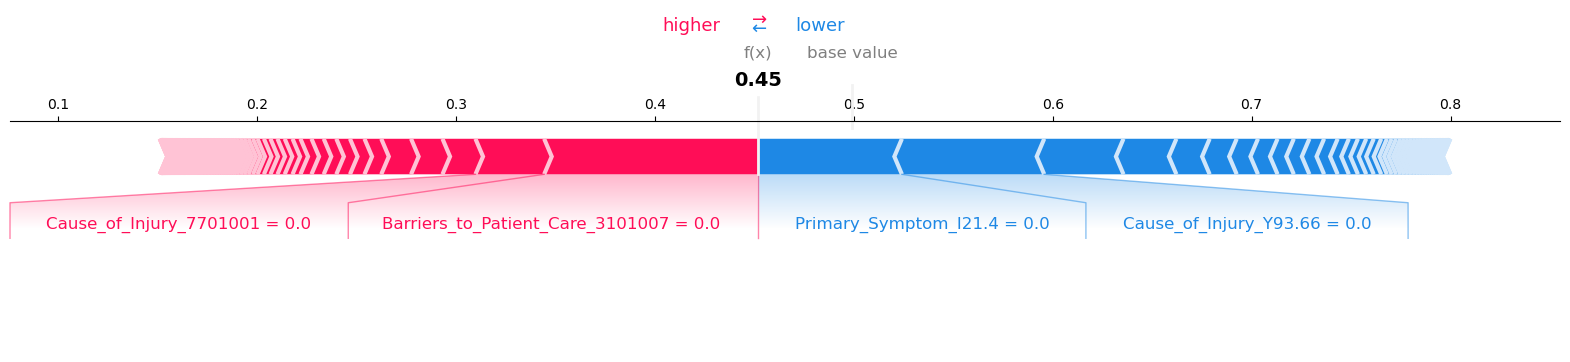

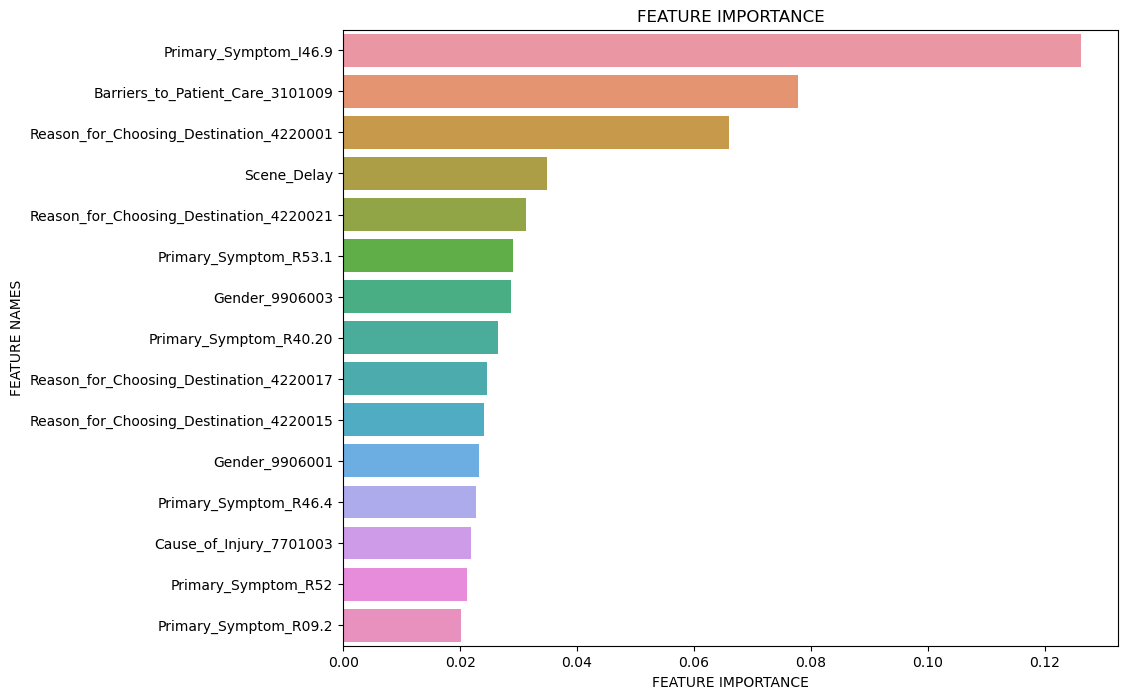

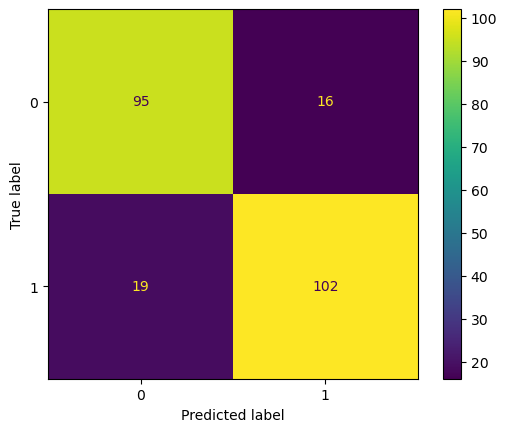

In [66]:
# Generate predictions and print some performance metrics

#NOTE: Due to the js from the shap library conflicting with the plotting functions of matplotlib, sometimes plots created in lower cells will show up in this one or other unrelated cells
# Execution order and the data itself is unchanged so these plots are still valid

y_pred = RF.predict(x_test)

print(classification_report(y_test, y_pred))

conf = confusion_matrix(y_test, y_pred, labels=RF.classes_)

disp = ConfusionMatrixDisplay(conf, display_labels=RF.classes_)
disp.plot()
plt.show()

In [67]:
# Generating feature importance
feat_imp = pd.DataFrame({'name':RF.feature_names_in_, 'imp':RF.feature_importances_})
feat_imp.sort_values(by='imp', ascending=False, inplace=True)
feat_imp.head(n=10)

In [72]:
 #Define size of bar plot
plt.figure(figsize=(10,8))
#Plot Searborn bar chart
sns.barplot(x=feat_imp['imp'][:15], y=feat_imp['name'][:15])
#Add chart labels
plt.title('FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.


Text(0, 0.5, 'FEATURE NAMES')

In [70]:
# Create a shap force plot to help visualize the impact breakdown for the features in a specific patient outcome

explainer = shap.TreeExplainer(RF)

chosen_x = ML_df.loc[743556].drop(columns=['patient_death'])

shap_values = explainer.shap_values(chosen_x)

shap.force_plot(explainer.expected_value[1], shap_values[1], chosen_x)

In [71]:
shap.force_plot(explainer.expected_value[1], shap_values[1], chosen_x, matplotlib=True, show=False)
plt.savefig('shap2.png')